In [2]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os
import shutil

from scipy import stats
import signac
import freud
import gsd.hoomd
import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs
from schmeud._schmeud import statics
from schmeud import ml
from tqdm import tqdm

from dataclasses import dataclass
from collections import defaultdict

from numba import njit

In [3]:
from monk import nb, prep, pair, render, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [4]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12, 0.04, 0.06, 0.07], '_status': {}}

In [5]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float
    prep: str

In [43]:
# output = defaultdict(list)

bins = np.linspace(-2, 2, 50)

for job in project:
    print(job)
    soft = None
    prep = job.sp["prep"]
    if prep != "ESL":
        continue
    print(prep)
    
    experiments = sorted(glob.glob(job.fn("experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"experiments/max-shear-{max_shear}/temp-{temp}/strob-softness_period-{period}.parquet"
        # new_df_path = f"experiments/max-shear-{max_shear}/temp-{temp}/softness-corr-frames_period-{period}.npz"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) != 0.1984 or float(max_shear) != 0.05:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            print("what!")
            continue
        
        # traj = gsd.hoomd.open(exper)

        soft_output2 = []
        frames = []
        print(sp)

        for frame, _, soft in dataset.rows():
            # print(frame)
            frames.append(frame)
            soft = np.array(soft)
            h, _ = np.histogram(soft, bins=bins, density=True)
            # soft_output.append(soft)
            soft_output2.append(h)
            
            # break
            # soft = (soft - soft.mean()) / soft.std()
            # snap = traj[frame]
        break
    # break
    if soft is None:
        continue
    else:
        break

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
ESL
Statepoint(max_shear=0.05, period=1000.0, temp=0.1984, prep='ESL')


In [29]:
output = defaultdict(list)

bins = np.linspace(-2, 2, 50)

for job in project:
    print(job)
    soft = None
    prep = job.sp["prep"]
    # if prep != "HTL":
    #     continue
    print(prep)
    
    experiments = sorted(glob.glob(job.fn("experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"experiments/max-shear-{max_shear}/temp-{temp}/strob-softness_period-{period}.parquet"
        # new_df_path = f"experiments/max-shear-{max_shear}/temp-{temp}/softness-corr-frames_period-{period}.npz"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            # print("what!")
            continue
        
        # traj = gsd.hoomd.open(exper)

        soft_output = []
        frames = []
        print(sp)

        for frame, _, soft in dataset.rows():
            # print(frame)
            frames.append(frame)
            soft = np.array(soft)
            # h, _ = np.histogram(soft, bins=bins, density=True)
            # soft_output.append(soft)
            # soft_output.append(h)
            soft_output.append(np.mean(soft))
            
            # break
            # soft = (soft - soft.mean()) / soft.std()
            # snap = traj[frame]
        output[sp].append(soft_output)
    #     break
    # # break
    # if soft is None:
    #     continue
    # else:
    #     break

634e14bc75836df75158fb15f379d8bb
HTL
Statepoint(max_shear=0.01, period=1000.0, temp=0.0496, prep='HTL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.0992, prep='HTL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.1488, prep='HTL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.1984, prep='HTL')
Statepoint(max_shear=0.02, period=1000.0, temp=0.0496, prep='HTL')
Statepoint(max_shear=0.02, period=1000.0, temp=0.0992, prep='HTL')
Statepoint(max_shear=0.02, period=1000.0, temp=0.1488, prep='HTL')
Statepoint(max_shear=0.02, period=1000.0, temp=0.1984, prep='HTL')
Statepoint(max_shear=0.03, period=1000.0, temp=0.0496, prep='HTL')
Statepoint(max_shear=0.03, period=1000.0, temp=0.0992, prep='HTL')
Statepoint(max_shear=0.03, period=1000.0, temp=0.1488, prep='HTL')
Statepoint(max_shear=0.03, period=1000.0, temp=0.1984, prep='HTL')
Statepoint(max_shear=0.05, period=1000.0, temp=0.0496, prep='HTL')
Statepoint(max_shear=0.05, period=1000.0, temp=0.0992, prep='HTL')
Statepoint(max_shear=0.05

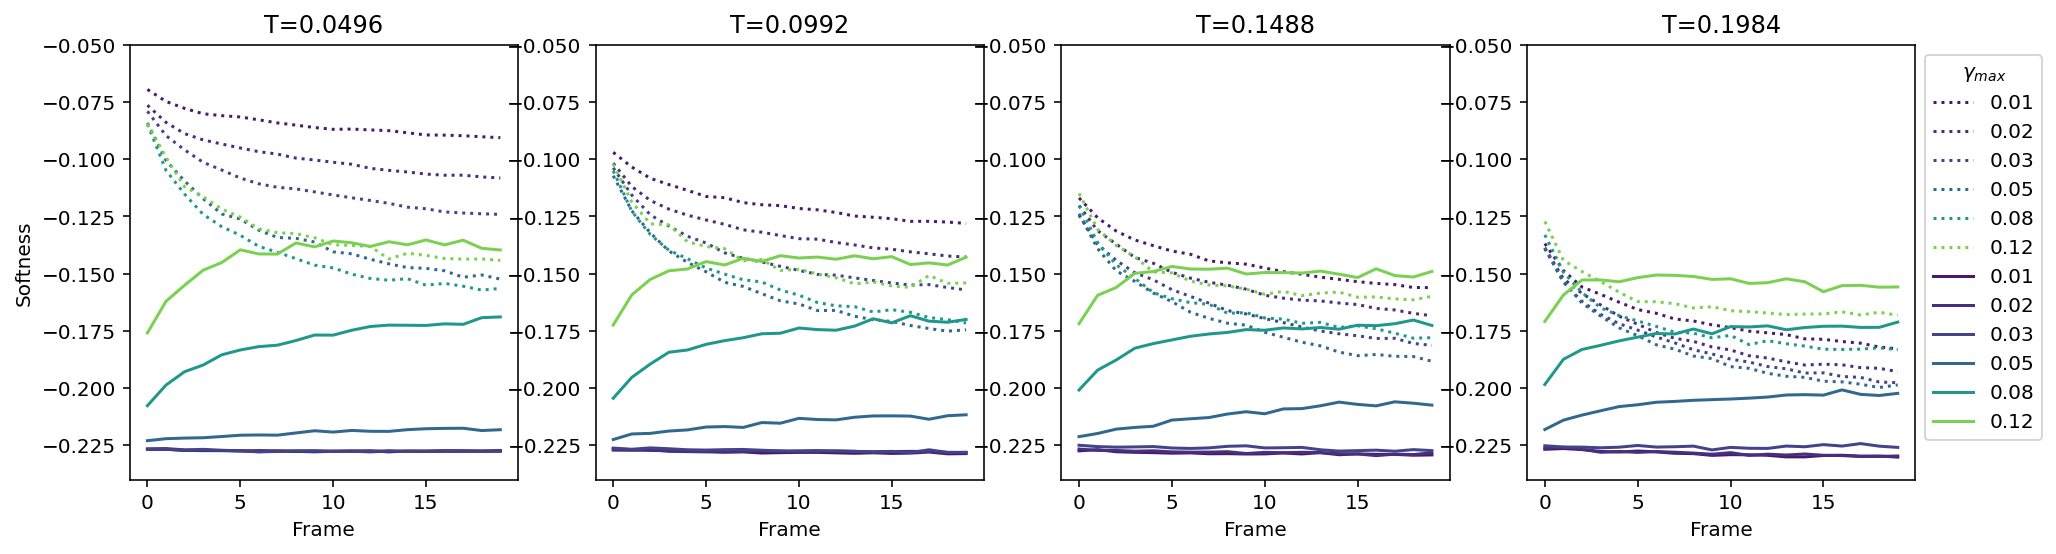

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

cmap = cm.viridis
norm = colors.Normalize(vmin=0.0, vmax=0.15)

temps = [0.0496, 0.0992, 0.1488, 0.1984]

axs[0].set_ylabel("Softness")

for t, a in zip(temps, axs):
    a.set_title(f"T={t}")
    a.set_xlabel("Frame")
    # a.set_ylabel("Softness")
    a.set_ylim(-.24, -0.05)

for key, val in output.items():
    

    if key.prep == "ESL":
        ls = "-"
    else:
        ls = ":"

    idx = temps.index(key.temp)

    axs[idx].plot(np.mean(val, axis=0), ls, color=cmap(norm(key.max_shear)), label=f"{key.max_shear}")

axs[-1].legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), title=r"$\gamma_{max}$")

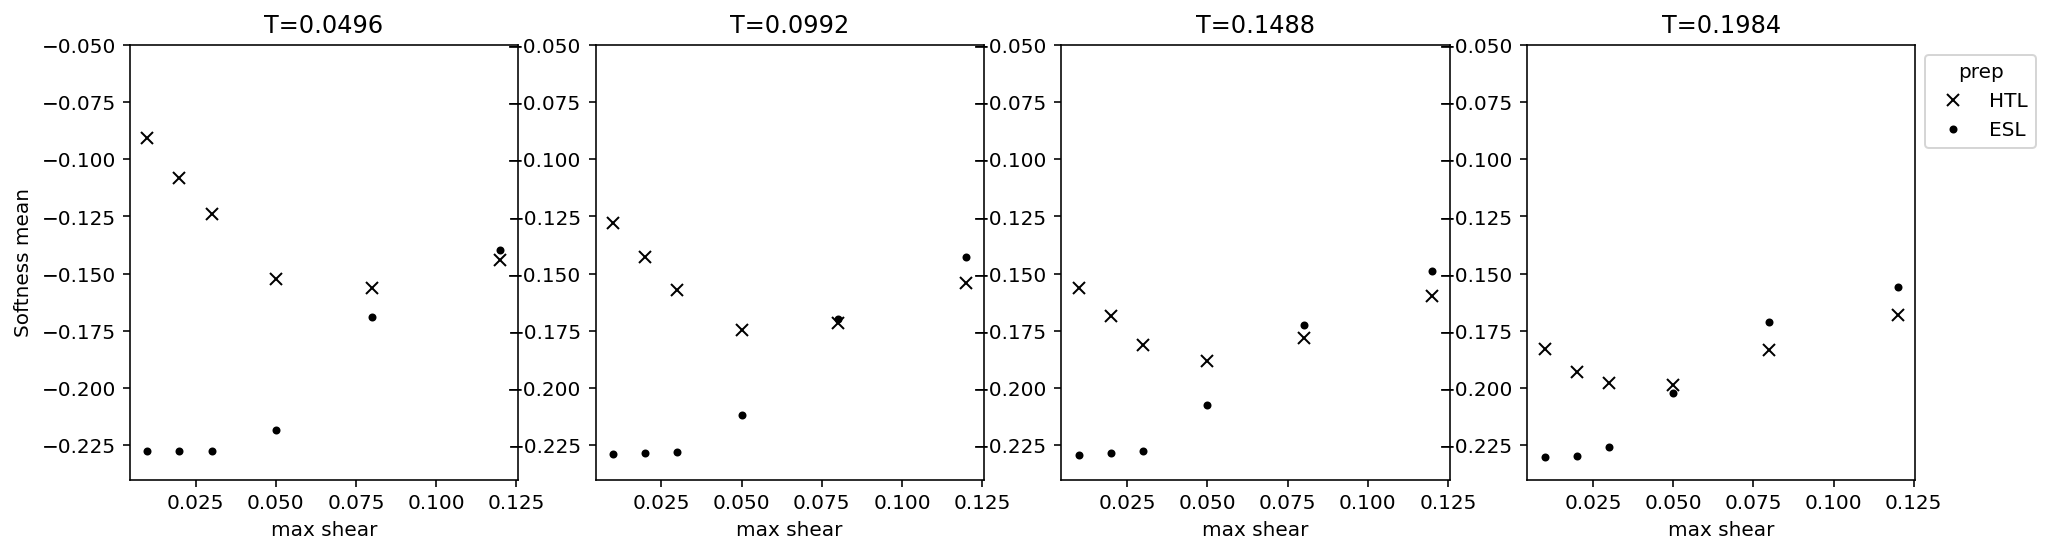

In [30]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

cmap = cm.viridis
norm = colors.Normalize(vmin=0.0, vmax=0.15)

temps = [0.0496, 0.0992, 0.1488, 0.1984]

axs[0].set_ylabel("Softness mean")

for t, a in zip(temps, axs):
    a.set_title(f"T={t}")
    a.set_xlabel("max shear")
    # a.set_ylabel("Softness")
    a.set_ylim(-.24, -0.05)

for key, val in output.items():
    

    if key.prep == "ESL":
        ls = "."
    else:
        ls = "x"

    idx = temps.index(key.temp)

    # axs[idx].plot(np.mean(val, axis=0), ls, color=cmap(norm(key.max_shear)),
    # label=f"{key.max_shear}")
    axs[idx].plot(key.max_shear, np.mean(val, axis=0)[-1], ls, color="k")

legend_elements = [mpl.lines.Line2D([0], [0], marker='x', lw=0, color="k", label='HTL'),
                   mpl.lines.Line2D([0], [0], marker='.', lw=0, color='k', label='ESL')]


axs[-1].legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1.0, 1.0), title=r"prep")

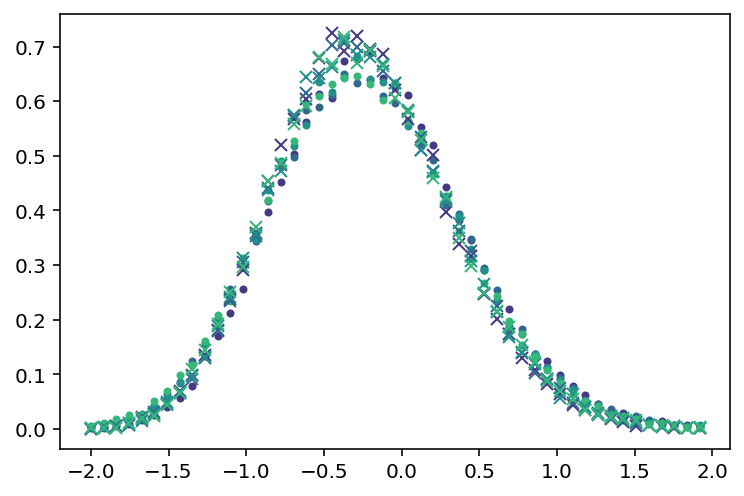

In [51]:
bins = np.linspace(-2, 2, 50)
cmap = cm.viridis
norm = colors.Normalize(-1, 5)
for idx, h in enumerate(soft_output[::5]):
    # h, bins = np.histogram(soft, bins=bins, density=True)
    # plt.hist(soft, bins=bins);
    plt.plot(bins[:-1], h, ".", color=cmap(norm(idx)))

bins = np.linspace(-2, 2, 50)
cmap = cm.viridis
norm = colors.Normalize(-1, 5)
for idx, h in enumerate(soft_output2[::5]):
    # h, bins = np.histogram(soft, bins=bins, density=True)
    # plt.hist(soft, bins=bins);
    plt.plot(bins[:-1], h, "x", color=cmap(norm(idx)))

In [31]:
output = defaultdict(list)

bins = np.linspace(-2, 2, 50)

for job in project:
    print(job)
    soft = None
    prep = job.sp["prep"]
    # if prep != "HTL":
    #     continue
    print(prep)
    
    experiments = sorted(glob.glob(job.fn("experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"experiments/max-shear-{max_shear}/temp-{temp}/strob-softness_period-{period}.parquet"
        # new_df_path = f"experiments/max-shear-{max_shear}/temp-{temp}/softness-corr-frames_period-{period}.npz"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            # print("what!")
            continue
        
        # traj = gsd.hoomd.open(exper)

        soft_output = []
        frames = []
        print(sp)

        for frame, _, soft in dataset.rows():
            # print(frame)
            frames.append(frame)
            soft = np.array(soft)
            # h, _ = np.histogram(soft, bins=bins, density=True)
            # soft_output.append(soft)
            # soft_output.append(h)
            soft_output.append(np.var(soft))
            
            # break
            # soft = (soft - soft.mean()) / soft.std()
            # snap = traj[frame]
        output[sp].append(soft_output)
    #     break
    # # break
    # if soft is None:
    #     continue
    # else:
    #     break

634e14bc75836df75158fb15f379d8bb
HTL
Statepoint(max_shear=0.01, period=1000.0, temp=0.0496, prep='HTL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.0992, prep='HTL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.1488, prep='HTL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.1984, prep='HTL')
Statepoint(max_shear=0.02, period=1000.0, temp=0.0496, prep='HTL')
Statepoint(max_shear=0.02, period=1000.0, temp=0.0992, prep='HTL')
Statepoint(max_shear=0.02, period=1000.0, temp=0.1488, prep='HTL')
Statepoint(max_shear=0.02, period=1000.0, temp=0.1984, prep='HTL')
Statepoint(max_shear=0.03, period=1000.0, temp=0.0496, prep='HTL')
Statepoint(max_shear=0.03, period=1000.0, temp=0.0992, prep='HTL')
Statepoint(max_shear=0.03, period=1000.0, temp=0.1488, prep='HTL')
Statepoint(max_shear=0.03, period=1000.0, temp=0.1984, prep='HTL')
Statepoint(max_shear=0.05, period=1000.0, temp=0.0496, prep='HTL')
Statepoint(max_shear=0.05, period=1000.0, temp=0.0992, prep='HTL')
Statepoint(max_shear=0.05

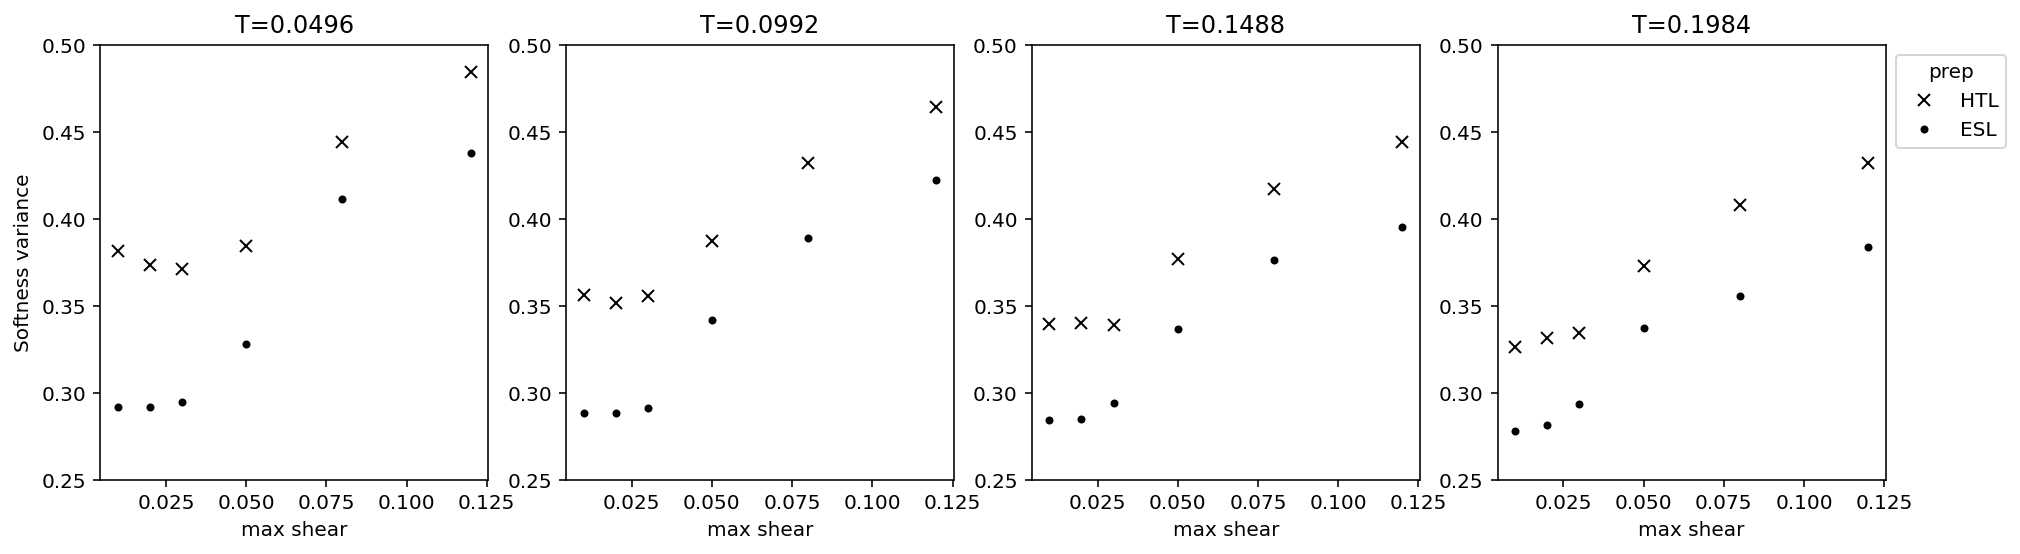

In [32]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

cmap = cm.viridis
norm = colors.Normalize(vmin=0.0, vmax=0.15)

temps = [0.0496, 0.0992, 0.1488, 0.1984]

axs[0].set_ylabel("Softness variance")

for t, a in zip(temps, axs):
    a.set_title(f"T={t}")
    a.set_xlabel("max shear")
    # a.set_ylabel("Softness")
    a.set_ylim(.25, 0.5)

for key, val in output.items():
    

    if key.prep == "ESL":
        ls = "."
    else:
        ls = "x"

    idx = temps.index(key.temp)

    # axs[idx].plot(np.mean(val, axis=0), ls, color=cmap(norm(key.max_shear)),
    # label=f"{key.max_shear}")
    axs[idx].plot(key.max_shear, np.mean(val, axis=0)[-1], ls, color="k")

legend_elements = [mpl.lines.Line2D([0], [0], marker='x', lw=0, color="k", label='HTL'),
                   mpl.lines.Line2D([0], [0], marker='.', lw=0, color='k', label='ESL')]


axs[-1].legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1.0, 1.0), title=r"prep")